## Task 1

Implement, on a quantum simulator of your choice, the following 4 qubits state $|\psi(\theta)>$ :
Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:


In [ ]:
from IPython.display import Image
Image(filename="2020-09-19 (6).png")

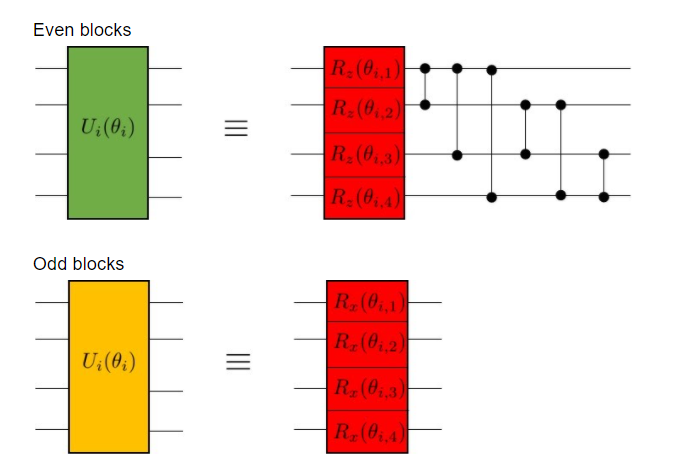

In [26]:
from IPython.display import Image
Image(filename="2020-09-19 (7).png")

The angles i, n are variational parameters, lying in the interval (0, 2), initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$\epsilon$ = min<sub>$\theta$</sub> || $|\psi(\theta)>$ - $|\phi>$ ||

Where |$\phi$> is a randomly generated vector on 4 qubits and the norm || $|v>$||, of a state $|v>$, simply denotes the sum of the squares of the components of $|v >$. The right set of parameters i,n can be found via any method of choice (e.g. grid-search or gradient descent)

We use Qiskit for this implementation.

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table

So, we import qiskit along with some other libraries which are Numpy for doing computations and Matplotlib for making plots.

In [28]:
from qiskit import *

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The number of qubits are defined as given in the question.

In [29]:
num_qubits = 4

Next, we define the even block as in the question. We use the standard gates given in qiskit for building this.

In [30]:
def even_block(given_circuit, thetaEvenLayer) :
    for qubit in range(num_qubits) :
        given_circuit.rz(thetaEvenLayer[qubit], qubit)
    for qubit1 in range(num_qubits - 1):
        for qubit2 in range(qubit1 + 1, num_qubits):
            given_circuit.cz(qubit1, qubit2)

This is followed by defining the odd block, again using the standard gates.

In [31]:
def odd_block(given_circuit, thetaOddLayer) :
    for qubit in range(num_qubits) :
        given_circuit.rx(thetaOddLayer[qubit], qubit)

Now using the above two functions of odd and even blocks, we make the circuit taking input of two parameters, the number of qubits and the matrix theta. The theta matrix is defined such that it has a total of (2 * L) rows where every set of two layers has one corresponding to the odd block and other of the even block. The matrix also has 4 columns in our case corresponding to the number of qubits in the circuit. Thus the total parameters are 8 * L.

In [32]:
def make_circuit(thetaParams, num_qubits) :
    circuit = QuantumCircuit(num_qubits)
    for layer in range(0, len(thetaParams), 2) :
        odd_block(circuit, thetaParams[layer])
        even_block(circuit, thetaParams[layer + 1])
        circuit.barrier()
    return circuit

Next is the function that defines the matrix theta where each element is generated randomly in the range (0, 2$\pi$)

In [33]:
def initialize_theta_params(layers, num_qubits) :
    return 2 * (np.pi) * np.random.random_sample((2 * layers, num_qubits))

In [34]:
def get_statevector(given_circuit) :
    statevector_backend = Aer.get_backend('statevector_simulator')
    qubits_statevector = execute(given_circuit, statevector_backend).result().get_statevector()
    return qubits_statevector

The vector $\phi$ is then defined randomly.

In [35]:
def random_statevector(num_qubits = 4):
    return quantum_info.random_statevector(2 ** num_qubits, seed = None).data

We then define the squared difference of the vector $\psi$ and $\phi$ using the epsilon function.

In [36]:
def epsilon(psi, phi) :
    difference = psi - phi
    return sum(difference.real ** 2 + difference.imag ** 2)

For calculating the parameters theta, we have used the gradient descent algorithm. To calculate the gradient of $\epsilon$ with respect to $\theta$, we defined the value of epsilon at a point $\theta + \delta$ and at another point $\theta - \delta$. This is then divided by $2 * \delta$. This gives us the gradient which is then multiplied by the learning rate and subtracted from the $\theta$ values before. 

In [37]:
def update_params(current_params, phi, learning_rate, delta) :
    cost_matrix = np.zeros(current_params.shape)
    for i in range(current_params.shape[0]) :
        for j in range(current_params.shape[1]) :
            current_params[i][j] += delta
            plus_delta = get_statevector(make_circuit(current_params, num_qubits))
            
            current_params[i][j] -= 2 * delta
            minus_delta = get_statevector(make_circuit(current_params, num_qubits))
            
            current_params[i][j] += delta
            cost_matrix[i][j] = (epsilon(plus_delta, phi) - epsilon(minus_delta, phi)) / (2 * delta)
    current_params -= learning_rate * cost_matrix
    
    return current_params

The above process of updating $\theta$ matrix is performed a number of times and the values are been updated accordingly. For each layer, there exists and optimum value of the learning rate and delta where the valye of $\epsilon$ is minimum.

In [47]:
def gradient_descent(phi, L, learning_rate = 0.1, delta = 0.05, num_iterations = 100):
    current_params = initialize_theta_params(L, num_qubits)
    X = []
    Y = []
    
    for i in range(num_iterations) :
        current_params = update_params(current_params, phi, learning_rate, delta)
        if i % 10 == 0:
            X.append(i)
            st = get_statevector(make_circuit(current_params, num_qubits))
            Y.append(epsilon(st, phi))
    return epsilon(get_statevector(make_circuit(current_params, num_qubits)), phi), X, Y

Now, we start out with the computations. We define phi which would remain constant throughout the whole analysis. Next we try to analyse the hyperparameters.

In [39]:
phi = random_statevector(num_qubits = 4)

The values of epsilon were calculated for 100 iterations using the different values of learning rate against the different layers from 1 to 10.

In [ ]:
min_losses = [ ] 
learning_rates = [ ]
 
for i in range(1, 10, 1):
    min_loss = []
    learning_rate = []
    for j in np.arange(0.01, 0.11, 0.01) :
        e, X, Y = gradient_descent(phi, i, learning_rate = j, delta = 0.01, num_iterations = 200)
        learning_rate.append(j)
        min_loss.append(min(Y))
    
    min_losses.append(min_loss)
    learning_rates.append(learning_rate)

We take in the minimum losses for each learning rate corresponding to each layer and plot it to see the results.

In [40]:
min_losses = [0, [1.9654233940734955, 2.0754480823022865, 1.3688030854790754, 1.0007235262856862, 0.5978849669489339, 
                  1.1590936273878296, 1.0024685252313863, 0.888067255090118, 1.154323438541542, 1.1264042074791798],
                 [1.0362865267672114, 1.3395333967777696, 1.4338869416999758, 0.5488165383558573, 0.36000889527882496,
                  0.6609621377186606, 0.40509702677331555, 0.43705385830647103, 0.4591924321953074, 0.49655830801898715],
                 [1.0781609015468776, 1.0157008734249404, 0.5128238275641555, 0.1886255604009551, 0.7408919102810753, 
                  0.420111021250065, 0.28445757180088466, 0.24846931379988324, 0.4055016067668147, 0.19277613791021736],
                 [1.5789409661376774, 0.43071357148657896, 0.44421132260807383, 0.25827983107118047, 0.22621578197998202,
                  0.39172767571808026, 0.22462954385374975, 0.2539835666801213, 0.2537033797581692, 0.11779301194820067],
                 [0.9851181844031363, 0.5684454411370619, 0.381900047790613, 0.22169659625233057, 0.2683292074282778,
                  0.1820288268196242, 0.08450739345560969, 0.12516497506024926, 0.11200137942761047, 0.020934938937874632],
                 [0.7800407575751327, 0.47235783461564684, 0.26955456912351977, 0.3280549472444808, 0.10224918089748529,
                  0.11983972461366404, 0.10134789620177581, 0.03466772563061812, 0.04351225438536081, 0.034902639077636625],
                 [0.5181924052612741, 0.34898725705640454, 0.28384701378050625, 0.11900984363910513, 0.10259016960208409,
                  0.07366503362416502, 0.03455799811499259, 0.018974098458827846, 0.024461548164565087, 0.048493189294271495],
                 [0.5796482956825345, 0.45924167853849485, 0.16829712090344814, 0.0843939816420166, 0.11427094217768849,
                  0.1075598396962254, 0.024161217947203537, 0.0238080569888483, 0.05712130341986252, 0.006918411336127367],
                 [0.4756568140678312, 0.20543046633210726, 0.14512449476307077, 0.028194562032602816, 0.044163750264743576,
                  0.04467491207141884, 0.009858101897463252, 0.013591621136457635, 0.011976382632352588, 0.04731260261740977],
                 [0.3626733139523758, 0.288708285987748, 0.16957468285188484, 0.014919908776291551, 0.01988484793937726,
                  0.05944764890935308, 0.006895389096139336, 0.0031280402359314917, 0.05528570997479058, 0.005840275537214383]]

In [42]:
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999]

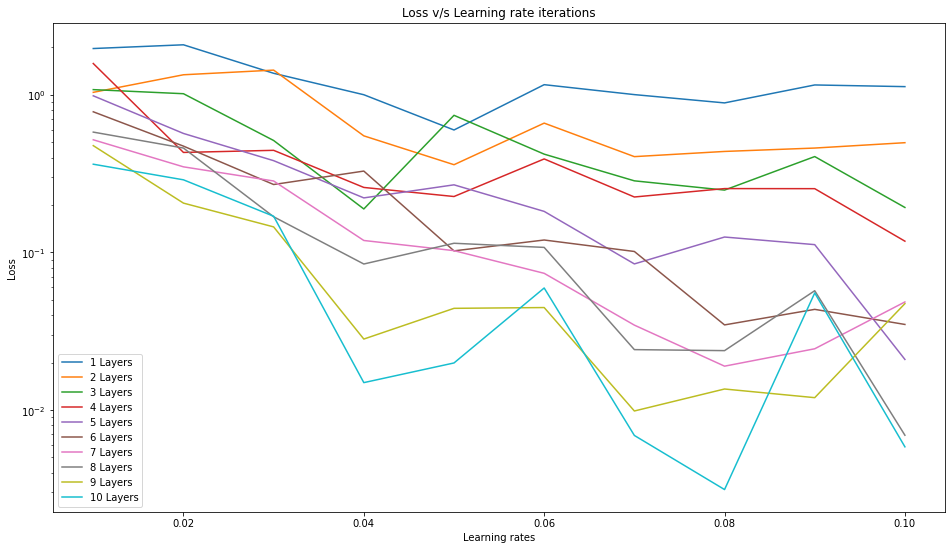

In [43]:
plt.figure(figsize=[16, 9])
plt.yscale('log')

for i in range(1, 11, 1):
    plt.plot(learning_rates, min_losses[i])
        
legendList = ['{} Layers'.format(i + 1) for i in range(10)]
plt.xlabel('Learning rates')
plt.ylabel('Loss')
plt.legend(legendList)
plt.title('Loss v/s Learning rate iterations')
plt.show()

From the above graph, we can clearly see the minimum values of learning rate against the different layers.

| Layers | Learning rate for minimum epsilon |
| --- | --- | 
| 1 | 0.05 | 
| 2 | 0.05 | 
| 3 | 0.04 | 
| 4 | 0.10 | 
| 5 | 0.10 | 
| 6 | 0.08 | 
| 7 | 0.08 | 
| 8 | 0.10 | 
| 9 | 0.07 | 
| 10 | 0.08 | 

Now, we calculate the value of minimum epsilon for each layer using the above table.

###### 1 Layer

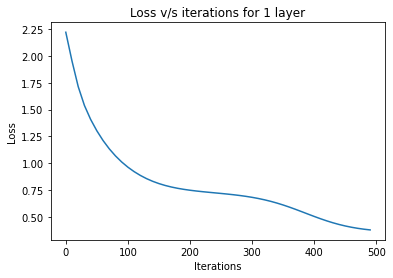

In [48]:
e, X, Y = gradient_descent(phi, 1, learning_rate = 0.05, delta = 0.01, num_iterations = 500)
plt.plot(X, Y)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 1 layer')
plt.show()

###### 2 Layers

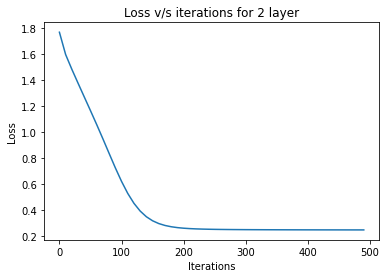

In [50]:
e2, X2, Y2 = gradient_descent(phi, 2, learning_rate = 0.05, delta = 0.01, num_iterations = 500)
plt.plot(X2, Y2)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 2 layer')
plt.show()

###### 3 Layers

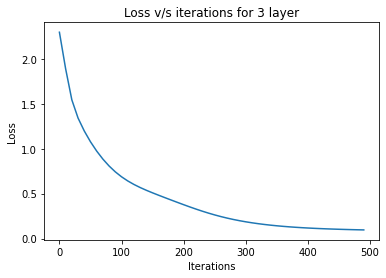

In [51]:
e3, X3, Y3 = gradient_descent(phi, 3, learning_rate = 0.04, delta = 0.01, num_iterations = 500)
plt.plot(X3, Y3)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 3 layer')
plt.show()

###### 4 Layers 

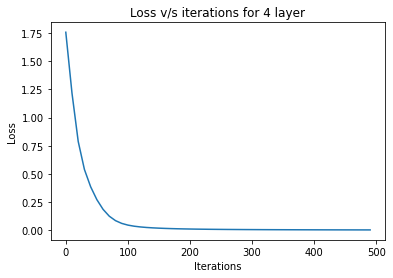

In [52]:
e4, X4, Y4 = gradient_descent(phi, 4, learning_rate = 0.10, delta = 0.01, num_iterations = 500)
plt.plot(X4, Y4)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 4 layer')
plt.show()

###### 5 Layers 

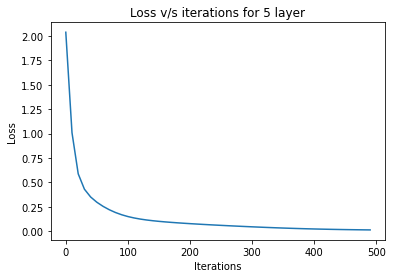

In [53]:
e5, X5, Y5 = gradient_descent(phi, 5, learning_rate = 0.10, delta = 0.01, num_iterations = 500)
plt.plot(X5, Y5)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 5 layer')
plt.show()

###### 6 Layers

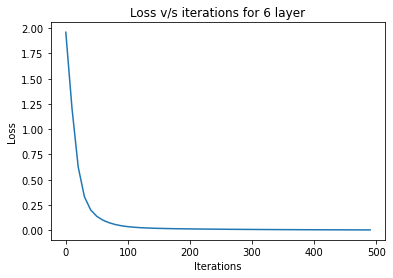

In [55]:
e6, X6, Y6 = gradient_descent(phi, 6, learning_rate = 0.08, delta = 0.01, num_iterations = 500)
plt.plot(X6, Y6)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 6 layer')
plt.show()

###### 7 Layers

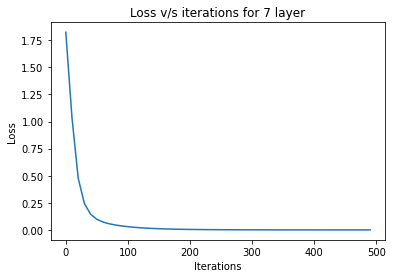

In [66]:
e7, X7, Y7 = gradient_descent(phi, 7, learning_rate = 0.08, delta = 0.01, num_iterations = 500)
plt.plot(X7, Y7)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 7 layer')
plt.show()

###### 8 Layers

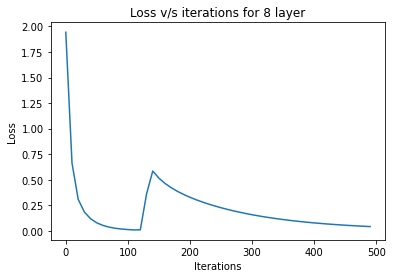

In [67]:
e8, X8, Y8 = gradient_descent(phi, 8, learning_rate = 0.10, delta = 0.01, num_iterations = 500)
plt.plot(X8, Y8)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 8 layer')
plt.show()

###### 9 Layers

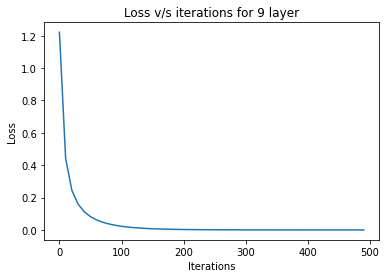

In [68]:
e9, X9, Y9 = gradient_descent(phi, 9, learning_rate = 0.07, delta = 0.01, num_iterations = 500)
plt.plot(X9, Y9)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 9 layer')
plt.show()

###### 10 Layers

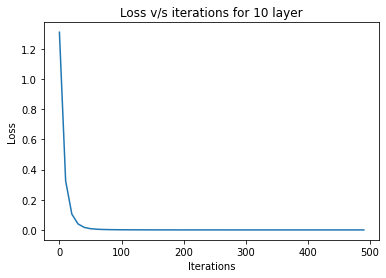

In [69]:
e10, X10, Y10 = gradient_descent(phi, 10, learning_rate = 0.08, delta = 0.01, num_iterations = 500)
plt.plot(X10, Y10)
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Loss v/s iterations for 10 layer')
plt.show()

##### Using the same learning rate for all layers

We also try and analyse using the same learning rate for all the layers over 500 iterations. The code below was run and the results are displayed as in the graph below.

In [ ]:
plt.figure(figsize=[16, 9])
plt.yscale('log')

min_distances = []
epsilons = []

for layer in range(1, 15, 1):
    min_distance, iterations, epsilon_values = gradient_descent(phi, layer, learning_rate = 0.05, delta = 0.05, num_iterations = 500)
    plt.plot(iterations, epsilon_values)
    
    epsilons.append(epsilon_values)
    min_distances.append(min_distance)
    
legendList = ['{} Layers'.format(i + 1) for i in range(10)]
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(legendList)
plt.title('Loss v/s optimization iterations')
plt.show()